# WhoAreYou?
Face Swapper uses artificial intelligence to detect faces on photos and replaces them with other faces of your choice.

This code is on base of this [Tutorial](https://learnopencv.com/face-swap-using-opencv-c-python/), we changed the face landmark model to media pipe. 

## Import requirements

In [2]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np 

# Static Images
## Load Images

In [34]:
## Draw 2 image
def plot_images(images, titles):
    for index, image in enumerate(images): 
        plt.subplot(1, 2, index+1); plt.imshow(image[...,::-1]); plt.title(titles[index])

In [142]:
src_image = cv2.imread('./images/trump.jpeg')
des_image = cv2.imread('./images/clinton.jpeg')

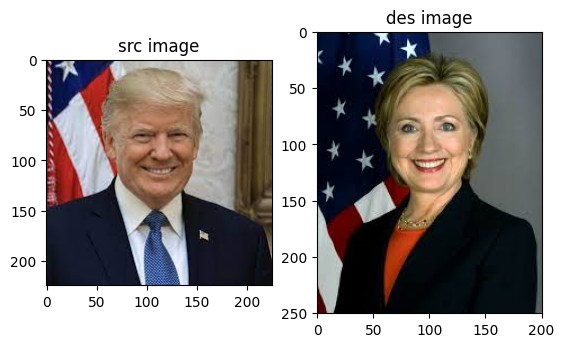

In [143]:
plot_images([src_image, des_image], ['src image', 'des image'])

## Facial Landmark Detection
The geometry of the two faces is very different, so we need to warp the source face a bit so that it covers the target face, we also want to make sure we don't wrap it beyond recognition. We first detect facial landmarks on both images using the [mediapipe](https://google.github.io/mediapipe/solutions/face_mesh#refine_landmarks). 

In [105]:
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

For statice images:

In [144]:
def draw_landmarks(image, landmarks):
    # draw the landmarks
    mp_drawing.draw_landmarks(
          image=image,
          landmark_list=landmarks,
          connections=mp_face_mesh.FACEMESH_TESSELATION,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_tesselation_style())

def get_landmarks(image):
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5
    ) as face_mesh:
    
        height, width, _ = image.shape

        # Convert the BGR image to RGB.
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb_image)

        if not results.multi_face_landmarks:
            print("No face landmark detected in the image...")
            return None
        if len(results.multi_face_landmarks) > 1:
            print("Too many faces founded, we consider first one!!!")

        landmarks = []

        face_landmarks = results.multi_face_landmarks[0]

        # Save the x, y of landmarks
        for lm in face_landmarks.landmark:
            x,y = int(lm.x * width), int(lm.y * height)
            landmarks.append((x, y))
        return landmarks, face_landmarks


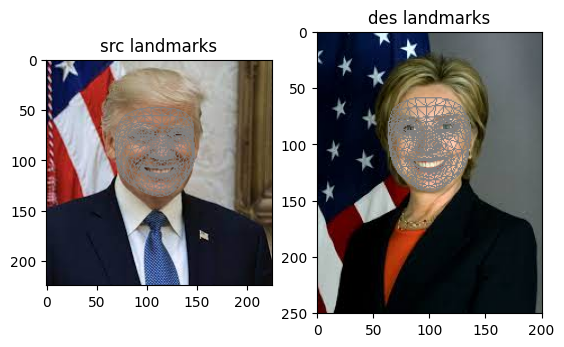

In [145]:
src_copy, des_copy = src_image.copy(), des_image.copy()

## Get landmarks
src_landmarks, src_normalized_landmarks = get_landmarks(src_image)
des_landmarks, des_normalized_landmarks = get_landmarks(des_image)

## Convert to np
src_np_points = np.array(src_landmarks)
des_np_points = np.array(des_landmarks)

## Draw landmarks
draw_landmarks(src_copy, src_normalized_landmarks)
draw_landmarks(des_copy, des_normalized_landmarks)

plot_images([src_copy, des_copy], ['src landmarks', 'des landmarks'])            


we do not and should not use all the points for face alignment. We need the points on the outer boundary of the face.

## Find Convex Hull
A boundary that does not have any concavities is called a “Convex Hull”. The previous image shows facial landmarks detected using Mediapipe in gray and below the convex hull of the points is shown in blue. The convex hull of a set of points can be calculated using OpenCV’s convexHull function.

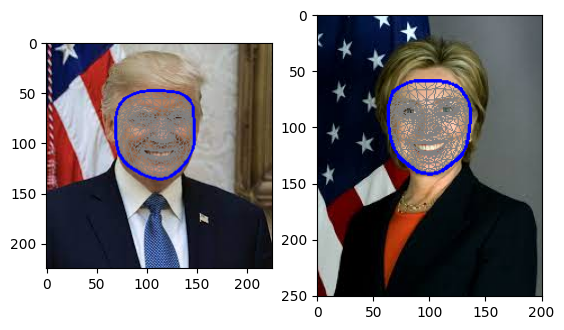

In [146]:
src_convexHull = cv2.convexHull(src_np_points)
des_convexHull = cv2.convexHull(des_np_points)

hullIndexs = [src_convexHull, des_convexHull]

for i, image in enumerate([src_copy, des_copy]):
    cv2.drawContours(image, [hullIndexs[i]], -1, (255, 0, 0), 2)
    plt.subplot(1,2, i+1); plt.imshow(image[...,::-1])

## Delaunay Triangulation 
Delaunay Triangulation The next step in alignment is to do a Delaunay triangulation of the points on the convex hull. This allows us to divide the face into smaller parts.

In [147]:
def get_triangles(convexhull, landmarks_points, np_points):
    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    indexs = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
        
        ## We need to find the indexs of triangles to tra
        try: 
            index_pt1 = np.where((np_points == pt1).all(axis=1))[0][0]
            index_pt2 = np.where((np_points == pt2).all(axis=1))[0][0]
            index_pt3 = np.where((np_points == pt3).all(axis=1))[0][0]
        except:
            index_pt1, index_pt2, index_pt3 = None, None, None
            
        if index_pt1 is None or index_pt2 is None or index_pt3 is None:
            continue
            
        indexs.append([index_pt1, index_pt2, index_pt3])

    return indexs


In [148]:
triangles_indexs = get_triangles(src_convexHull, src_landmarks, src_np_points)

assert len(triangles_indexs) != 0, "We can't find any triangles."

## Affine warp triangles:
The final steps of face alignment to to consider corresponding triangles between the source face and the target face, and affine warp the source face triangle onto the target face

In [149]:
def warp_triangle(src, des, s_triangle, d_triangle, new_face):
    # Find bounding rectangle for each triangle
    s_rect = cv2.boundingRect(np.array([s_triangle]))
    d_rect = cv2.boundingRect(np.array([d_triangle]))
    
    (xs, ys, ws, hs) = s_rect
    (xd, yd, wd, hd) = d_rect
    
    ## offset points by left-top corner of the respective rectangle
    s_points = np.array([
            [s_triangle[0][0] - xs, s_triangle[0][1] - ys],
            [s_triangle[1][0] - xs, s_triangle[1][1] - ys],
            [s_triangle[2][0] - xs, s_triangle[2][1] - ys]
    ], np.int32)
   
    d_points = np.array([
            [d_triangle[0][0] - xd, d_triangle[0][1] - yd],
            [d_triangle[1][0] - xd, d_triangle[1][1] - yd],
            [d_triangle[2][0] - xd, d_triangle[2][1] - yd]
    ], np.int32)
    
    # Get mask by filling triangle
    des_mask = np.zeros((hd, wd), dtype=np.int8)
    cv2.fillConvexPoly(des_mask, d_points, 255)

    # Apply warpImage to small rectangular patches
    src_cropped_triangle = src[ys: ys+hs, xs: xs+ws]
    
    warpMat = cv2.getAffineTransform(np.float32(s_points), np.float32(d_points))
    
    # Apply the Affine Transform just found to the src image
    warped_triangle = cv2.warpAffine(src_cropped_triangle, warpMat, (wd, hd), None,  flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=des_mask)
    
    # Copy triangular region of the rectangular patch to the output image
    new_face_area = new_face[yd: yd + hd, xd: xd + wd]
    new_face_area_gray = cv2.cvtColor(new_face_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(new_face_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)
    new_face_area = cv2.add(new_face_area, warped_triangle)
    new_face[yd: yd + hd, xd:xd + wd] = new_face_area

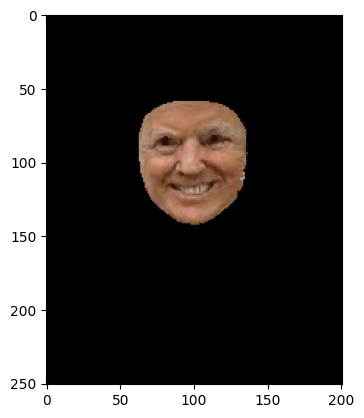

In [150]:
new_face = np.full_like(des_image,0, dtype=np.uint8)
for _, index in enumerate(triangles_indexs):
    src_triangle, des_triangle = [], []
    for apex in index:
        src_triangle.append(src_landmarks[apex])
        des_triangle.append(des_landmarks[apex])
    
    warp_triangle(src_image, des_image, src_triangle, des_triangle, new_face)

plt.imshow(new_face[...,::-1])    

##  Seamless Cloning : 
Image warping alone looks pretty bad. Combine it with Seamless Cloning and the results are magical! You can see the result of seamleass cloning below:

In [151]:
def swap_new_face(dest_image, dest_convexHull, new_face):
    dest_image_gray =  cv2.cvtColor(dest_image, cv2.COLOR_BGR2GRAY)
    face_mask = np.zeros_like(dest_image_gray)
    head_mask = cv2.fillConvexPoly(face_mask, dest_convexHull, 255)
    face_mask = cv2.bitwise_not(head_mask)

    head_without_face = cv2.bitwise_and(dest_image, dest_image, mask=face_mask)
    result = cv2.add(head_without_face, new_face)

    (x, y, w, h) = cv2.boundingRect(dest_convexHull)
    center_face = (int((x + x + w) / 2), int((y + y + h) / 2))

    return cv2.seamlessClone(result, dest_image, head_mask, center_face, cv2.NORMAL_CLONE)

In [152]:
result = swap_new_face(dest_image=des_image,
                                   dest_convexHull=des_convexHull, new_face=new_face)
cv2.imwrite('images/result.jpeg', result)

True

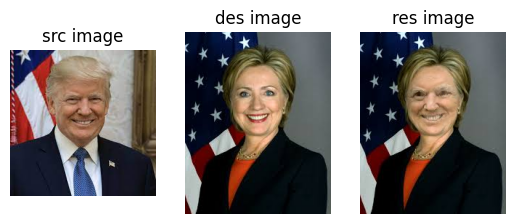

In [153]:
plt.subplot(131); plt.imshow(src_image[...,::-1]);plt.title('src image'); plt.axis('off');
plt.subplot(132); plt.imshow(des_image[...,::-1]);plt.title('des image'); plt.axis('off');
plt.subplot(133); plt.imshow(result[...,::-1]);plt.title('res image'); plt.axis('off');